In [15]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
num_workers = 0
batch_size = 64
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

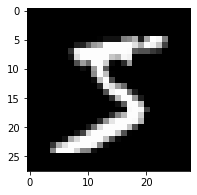

In [17]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
img = np.squeeze(images[0])
fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [18]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()        
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)        
        self.fc4 = nn.Linear(hidden_dim, output_size)        
        self.dropout = nn.Dropout(0.3)        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)
        return out

In [19]:


class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)        
        self.fc4 = nn.Linear(hidden_dim*4, output_size)        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = F.tanh(self.fc4(x))

        return out

In [20]:
# Discriminator hyperparams
input_size = 784
d_output_size = 1
d_hidden_size = 32
z_size = 100
g_output_size = 784
g_hidden_size = 32

In [21]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


In [22]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [23]:
# Optimizers
lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)


In [24]:
import pickle as pkl
num_epochs = 100
samples = []
losses = []
print_every = 400
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):                
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1 
        
        #TRAIN THE DISCRIMINATOR        
        d_optimizer.zero_grad()
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
       
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()        
        
        #TRAIN THE GENERATOR
        g_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)    

        g_loss.backward()
        g_optimizer.step()
        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
    
    losses.append((d_loss.item(), g_loss.item()))    
   
    G.eval() 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() 

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)


/home/nebex/.local/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.4089 | g_loss: 0.6353
Epoch [    1/  100] | d_loss: 1.0095 | g_loss: 2.7342
Epoch [    1/  100] | d_loss: 1.4750 | g_loss: 0.6014
Epoch [    2/  100] | d_loss: 1.2585 | g_loss: 1.3530
Epoch [    2/  100] | d_loss: 1.1325 | g_loss: 1.4759
Epoch [    2/  100] | d_loss: 1.4595 | g_loss: 0.6582
Epoch [    3/  100] | d_loss: 1.2652 | g_loss: 0.8110
Epoch [    3/  100] | d_loss: 0.8483 | g_loss: 2.1682
Epoch [    3/  100] | d_loss: 0.8908 | g_loss: 1.8963
Epoch [    4/  100] | d_loss: 1.3215 | g_loss: 0.9052
Epoch [    4/  100] | d_loss: 1.0990 | g_loss: 2.4579
Epoch [    4/  100] | d_loss: 0.9843 | g_loss: 1.8035
Epoch [    5/  100] | d_loss: 1.1931 | g_loss: 1.3636
Epoch [    5/  100] | d_loss: 1.0754 | g_loss: 1.9281
Epoch [    5/  100] | d_loss: 1.2577 | g_loss: 1.3278
Epoch [    6/  100] | d_loss: 0.9245 | g_loss: 3.6763
Epoch [    6/  100] | d_loss: 1.2274 | g_loss: 0.9585
Epoch [    6/  100] | d_loss: 1.1981 | g_loss: 1.0932
Epoch [    7/  100] | d_loss

Epoch [   51/  100] | d_loss: 1.5783 | g_loss: 0.8486
Epoch [   52/  100] | d_loss: 1.3696 | g_loss: 0.8430
Epoch [   52/  100] | d_loss: 1.3475 | g_loss: 0.9203
Epoch [   52/  100] | d_loss: 1.3070 | g_loss: 1.1937
Epoch [   53/  100] | d_loss: 1.2189 | g_loss: 1.0165
Epoch [   53/  100] | d_loss: 1.2411 | g_loss: 1.0108
Epoch [   53/  100] | d_loss: 1.4366 | g_loss: 1.0379
Epoch [   54/  100] | d_loss: 1.3341 | g_loss: 0.8153
Epoch [   54/  100] | d_loss: 1.1659 | g_loss: 1.1428
Epoch [   54/  100] | d_loss: 1.3105 | g_loss: 1.0156
Epoch [   55/  100] | d_loss: 1.3967 | g_loss: 1.0226
Epoch [   55/  100] | d_loss: 1.2259 | g_loss: 1.4920
Epoch [   55/  100] | d_loss: 1.3000 | g_loss: 0.9324
Epoch [   56/  100] | d_loss: 1.3251 | g_loss: 1.0355
Epoch [   56/  100] | d_loss: 1.2571 | g_loss: 1.0971
Epoch [   56/  100] | d_loss: 1.3056 | g_loss: 0.8827
Epoch [   57/  100] | d_loss: 1.2919 | g_loss: 1.2869
Epoch [   57/  100] | d_loss: 1.1821 | g_loss: 1.0202
Epoch [   57/  100] | d_loss

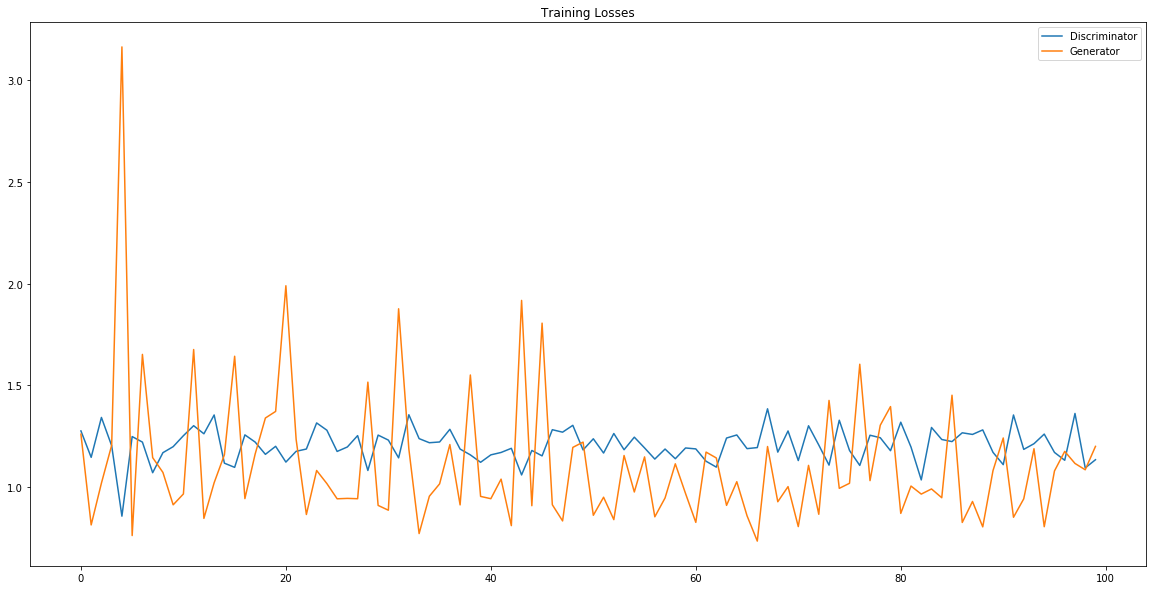

In [31]:
plt.figure(figsize=(20,10))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [26]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [27]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

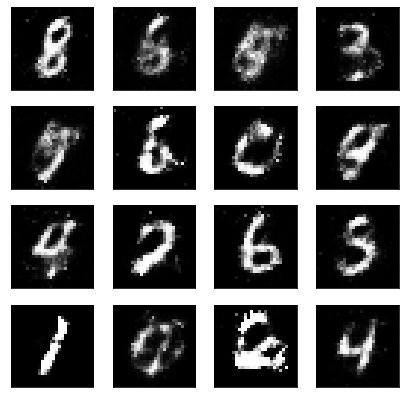

In [28]:
view_samples(-1, samples)

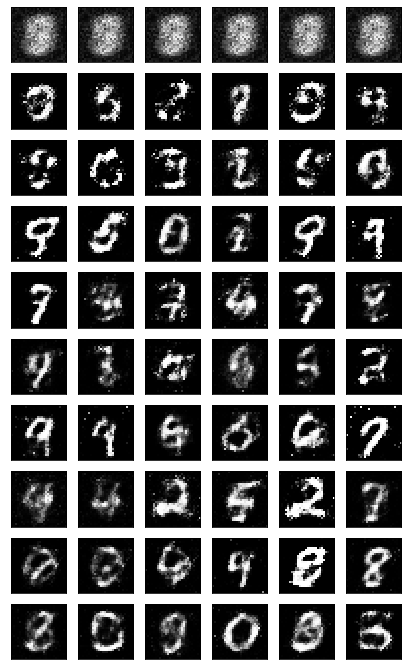

In [29]:
rows = 10 
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/home/nebex/.local/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


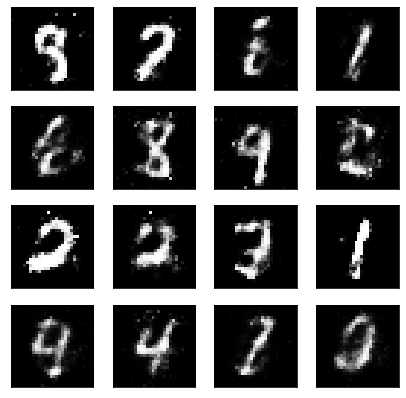

In [30]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
G.eval() # eval mode
rand_images = G(rand_z)
view_samples(0, [rand_images])